$$ \LARGE
\underline{\textbf{Problema 1}}
$$

Se tiene una placa cuadrada de aluminio cuyos bordes están en las condiciones que se indican en la
figura: tres lados a temperaturas fijas y otro, el inferior, aislado térmicamente (flujo de calor igual a
cero). Encuentre, utilizando el método de diferencias finitas, los valores de temperatura y flujo de
calor para cada punto. Utilice primero la grilla señalada y luego generalice el problema a un número
variable de nodos en cada eje de coordenadas. Haga un estudio del tiempo de cálculo en función del
tamaño del sistema.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

$$
$$

$$ \LARGE
\underline{\textbf{Problema 1 versión chapa}}
$$

In [2]:
class Chapa:
    def __init__(self, nx, ny=None):
        self.nx = nx
        if ny is None:
            self.ny = nx
        else:
            self.ny = ny
        self.nk = self.nx * self.ny

    # entonces tendrías un método de definir la matriz:
    def makematriz(self, Ta, Tb, Tc, Td):
        beta = self.nx/self.ny
        b = np.zeros([self.nx*self.ny, 1])  # Conviene que sea de ceros
        M = np.eye(self.nx*self.ny)
        nx = self.nx
        ny = self.ny
        for k in range(self.nk):
            if k == 0:
                b[k] = (Ta+Tb)/2
            elif k == (nx-1):
                b[k] = (Tc+Tb)/2
            elif k == nx*ny-nx:
                b[k] = (Ta+Td)/2
            elif k == nx*ny-1:
                b[k] = (Tc+Td)/2
            elif k < nx-1:
                b[k] = Tb
            elif k > nx*ny-1-nx:
                b[k] = Td
            elif k % nx == 0:
                b[k] = Ta
            elif (k+1) % nx == 0:  # si no pongo parentesis da mal
                b[k] = Tc
            else:
                M[k, k] = -2*(1+beta**2)
                M[k, k-1] = 1
                M[k, k+1] = 1
                M[k, k-nx] = beta**2
                M[k, k+nx] = beta**2
        return M, b

    # y un método de solución:
    def solve(self, M, b):
        T = np.linalg.solve(M, b)
        T_matriz = T.reshape(self.nx, self.ny)
        T_matriz = T_matriz[::-1]
        return T_matriz

In [3]:
Ta, Tb, Tc, Td = (75, 0, 50, 100)

lachapa = Chapa(10)

In [4]:
M_2, b_2 = lachapa.makematriz(Ta, Tb, Tc, Td)

In [5]:
T_matriz_2 = lachapa.solve(M_2, b_2)

Text(0, 0.5, ' j ')

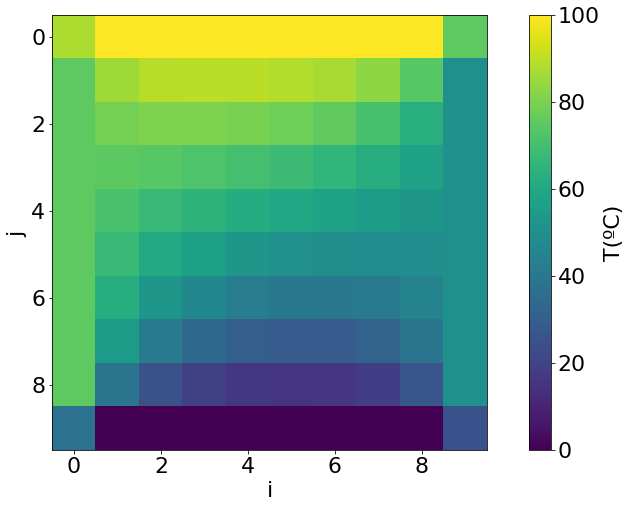

In [6]:
plt.rc('figure', figsize=(15,8))
plt.rc('font', size=22)
mapable = plt.imshow(T_matriz_2)
cbar = plt.colorbar(mapable)
cbar.set_label('T(ºC)')
plt.xlabel(' i ')
plt.ylabel(' j ')

In [7]:
ns = np.logspace(1, 2, 10).astype(int)

$$
$$

$ \Large
\textbf{Determino el tiempo de calculo del sistema en función de la resolución de la grilla}
$

In [8]:
dts = []
for ni in ns:
    thischapa = Chapa(ni)
    M, b = thischapa.makematriz(Ta, Tb, Tc, Td)
    t1 = time.time()
    thischapa.solve(M, b)
    t2 = time.time()
    dts.append(t2-t1)

In [9]:
dts

[0.0,
 0.0,
 0.004003286361694336,
 0.002986907958984375,
 0.007924556732177734,
 0.02800464630126953,
 0.0970008373260498,
 0.4139981269836426,
 1.5059988498687744,
 5.6831583976745605]

Ahora hay que ver el escaleo. Esto tiene que seguir una ley $dt = Nx^p$ , donde $p$ viene dado por el conteo de operaciones en la triangulación de gauss.

$$
log{(dt)}=p \cdot log(x)+log(N)
$$

In [10]:
model = np.polyfit(np.log10(ns[2:]), np.log10(dts[2:]), 1)

No considero los dos puntos porque a veces en dts son 0 y estamos calculando el logaritmo

In [11]:
model

array([ 4.3287796 , -8.06787808])

polyfit resuelve el polinomio devolviendo los valores de $p$ y de $log(N)$

resulta que:

$p\ =\ model[0]$

$ \large
Creo\ una\ función\ de\ 1^{er}\ orden\ con\ las\ constantes\ obtenidas
$

In [12]:
function = np.poly1d(model)

In [13]:
function

poly1d([ 4.3287796 , -8.06787808])

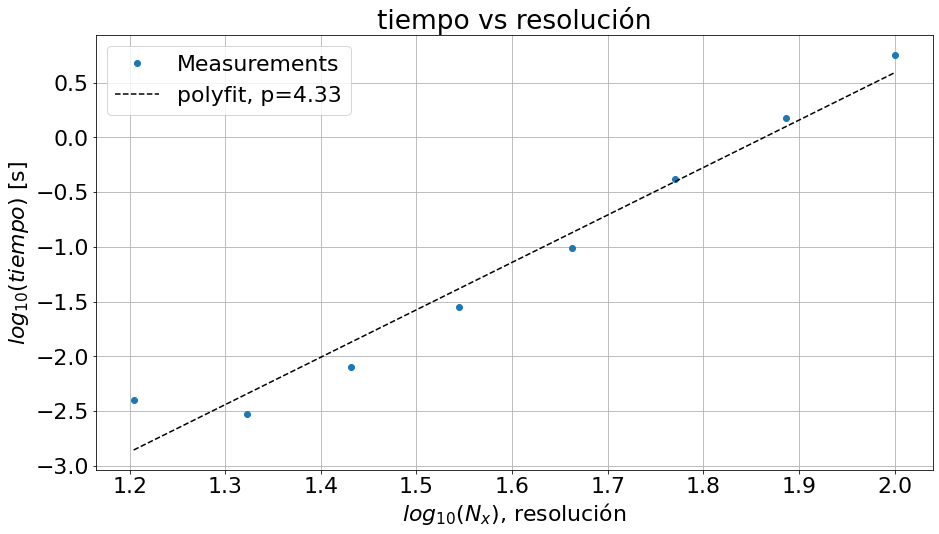

In [14]:
plt.plot(np.log10(ns[2:]), np.log10(dts[2:]), 'o', label='Measurements')  # 
plt.plot(np.log10(ns[2:]), function(np.log10(ns[2:])), '--k', label=f'polyfit, p={model[0]:3.2f}')
plt.xlabel(r'$log_{10} (N_x) $, resolución')
plt.ylabel(r'$log_{10} (tiempo) $ [s]')
plt.title('tiempo vs resolución')
plt.grid('on')
plt.legend()